# API de Acesso

In [1]:
import io
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xml.etree.ElementTree as et

## JSON

Com a API coingecko (https://www.coingecko.com/en/api), é possível acessar o preço atual de diversas criptomoedas e a série histórica de valores para diversos períodos de tempo.

In [2]:
currencies = ['usd','gbp','brl','cny']

baseUrl = 'https://api.coingecko.com/api/v3/simple/price?ids=bitcoin&vs_currencies='
for currency in currencies:
    url = baseUrl + currency
    price = requests.get(url).json()['bitcoin'][currency]
    print('Preço do bitcoin em ' + currency.upper() + ': ' + str(price))

Preço do bitcoin em USD: 11062.95
Preço do bitcoin em GBP: 8564.98
Preço do bitcoin em BRL: 59644
Preço do bitcoin em CNY: 74885


In [3]:
NUMBER_OF_DAYS = 5

url = 'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=USD&days=' + str(NUMBER_OF_DAYS)
historical = requests.get(url).json()['prices']
days = [datetime.fromtimestamp(x/1000).strftime('%m-%d %H') for (x,y) in historical]
prices = [y for (x,y) in historical]

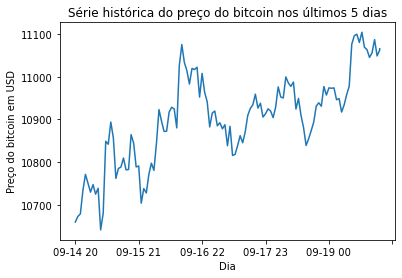

In [4]:
fig, ax = plt.subplots(1,1)
ax.plot(days,prices)
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
plt.title('Série histórica do preço do bitcoin nos últimos {} dias'.format(NUMBER_OF_DAYS))
plt.ylabel('Preço do bitcoin em USD')
plt.xlabel('Dia')
plt.show()

## XML

Usando a API do banco mundial (https://datahelpdesk.worldbank.org/knowledgebase/articles/889386-developer-information-overview) é possível monitorar alguns indicadores de diversos países

In [5]:
# Trecho que cria um dicionário entre o nome de um país (como Brasil) para um código de 3 digítos (BRA).
# Usado para trazer mais versatilidade, visto que para gerar um gráfico de um indicador basta saber o nome
# do país que de deseja e o nome do indicador na API do Banco Mundial

baseUrl = 'http://api.worldbank.org/v2/country?page='
countryList = {}
i = 1
while True:
    url = baseUrl + str(i)
    countries = requests.get(url).content
    x = et.parse(io.StringIO(countries.decode("utf-8")))
    root = x.getroot()
    if(root.get('page') == root.get('pages')):
        break
    for child in root:
        # Filtro de macrorregiões que são devolvidas pela API, como "Africa" ou "Asia"
        if(child.find('{http://www.worldbank.org}capitalCity').text != None):
            countryList[child.find('{http://www.worldbank.org}name').text] = child.get('id')
    i += 1

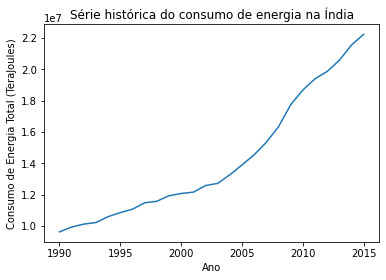

In [6]:
def indicatorGraph(country, indicator, xlabel = None, ylabel = None, title = None):
    url = 'http://api.worldbank.org/v2/country/' + countryList[country] + '/indicator/' + indicator
    data = requests.get(url).content
    x = et.parse(io.StringIO(data.decode('utf-8')))
    root = x.getroot()
    historicalIndicator = {}
    for child in root:
        value = child.find('{http://www.worldbank.org}value').text
        if(value != None):
            historicalIndicator[child.find('{http://www.worldbank.org}date').text] = value
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.plot([int(x) for x in historicalIndicator.keys()],[float(x) for x in historicalIndicator.values()])
    
gdp = 'NY.GDP.MKTP.CD' # Código do indicador do PIB no Banco Mundial
electricityaccess = '1.1_ACCESS.ELECTRICITY.TOT'
energyconsumption = '1.1_TOTAL.FINAL.ENERGY.CONSUM'
indicatorGraph('India',energyconsumption,'Ano','Consumo de Energia Total (TeraJoules)','Série histórica do consumo de energia na Índia')

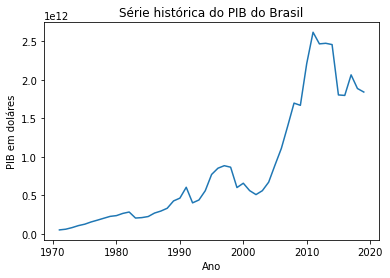

In [7]:
indicatorGraph('Brazil',gdp,'Ano','PIB em doláres','Série histórica do PIB do Brasil')

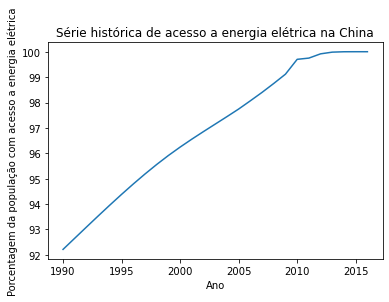

In [8]:
indicatorGraph('China',electricityaccess,'Ano','Porcentagem da população com acesso a energia elétrica', 'Série histórica de acesso a energia elétrica na China')